# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
## импортируем необходимые  библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

import warnings
warnings.filterwarnings('ignore')


In [2]:
df_0 = pd.read_csv('/datasets/geo_data_0.csv')
df_1 = pd.read_csv('/datasets/geo_data_1.csv')
df_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
data_list = [df_0, df_1, df_2]
region_list = ['Первый регион', 'Второй регион', 'Третий регион']

In [4]:
for data, region in zip(data_list, region_list):
    
    print (region)
    display (data.head())
    display (data.info())
    print ('Размерность:', data.shape)
    display ('Количество пропущенных значений:', data.isna().sum())
    print ('Количество  дубликатов строк:', data.duplicated().sum())
    print ('Количество  дубликатов ID:', data['id'].duplicated().sum())

Первый регион


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Размерность: (100000, 5)


'Количество пропущенных значений:'

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Количество  дубликатов строк: 0
Количество  дубликатов ID: 10
Второй регион


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Размерность: (100000, 5)


'Количество пропущенных значений:'

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Количество  дубликатов строк: 0
Количество  дубликатов ID: 4
Третий регион


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Размерность: (100000, 5)


'Количество пропущенных значений:'

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Количество  дубликатов строк: 0
Количество  дубликатов ID: 4


#### Представлены данные о качестве нефти и объёмов её запасов для  трех разных регионов. Каждый из трех датасетов  содержит  100 000 строк. Пропуски в данных отсутсвуют. Дубликатов строк не обнаружено. Есть дубликаты в колонке ID (уникальный идентификатор скважины). Удалим строки, где дублируются ID скважин. 


In [5]:
for data, region in zip(data_list, region_list):
    data.drop_duplicates('id', inplace=True)
    print(data.shape) 

(99990, 5)
(99996, 5)
(99996, 5)


#### Удалим стобец id во всех датафреймах. Он уникален для каждой скважины и не нужен для дальнейших исследований.

In [6]:
for data, region in zip(data_list, region_list):
    data.drop(['id'], axis=1, inplace=True)
    print(region)
    display (data.head())


Первый регион


,f0,f1,f2,product
0,0.705745,-0.497823,1.221170,105.280062
1,1.334711,-0.340164,4.365080,73.037750
2,1.022732,0.151990,1.419926,85.265647
3,-0.032172,0.139033,2.978566,168.620776
4,1.988431,0.155413,4.751769,154.036647


Второй регион


,f0,f1,f2,product
0,-15.001348,-8.276000,-0.005876,3.179103
1,14.272088,-3.475083,0.999183,26.953261
2,6.263187,-5.948386,5.001160,134.766305
3,-13.081196,-11.506057,4.999415,137.945408
4,12.702195,-8.147433,5.004363,134.766305


Третий регион


,f0,f1,f2,product
0,-1.146987,0.963328,-0.828965,27.758673
1,0.262778,0.269839,-2.530187,56.069697
2,0.194587,0.289035,-5.586433,62.871910
3,2.236060,-0.553760,0.930038,114.572842
4,-0.515993,1.716266,5.899011,149.600746


#### Посмотрим на сновные статистические показатели для каждого датафрейма.

Первый регион


,f0,f1,f2,product
count,99990.000000,99990.000000,99990.000000,99990.000000
mean,0.500454,0.250141,2.502629,92.499684
std,0.871844,0.504430,3.248149,44.288304
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072572,-0.200877,0.287784,56.497069
50%,0.502405,0.250252,2.515969,91.847928
75%,1.073626,0.700640,4.715035,128.563699
max,2.362331,1.343769,16.003790,185.364347


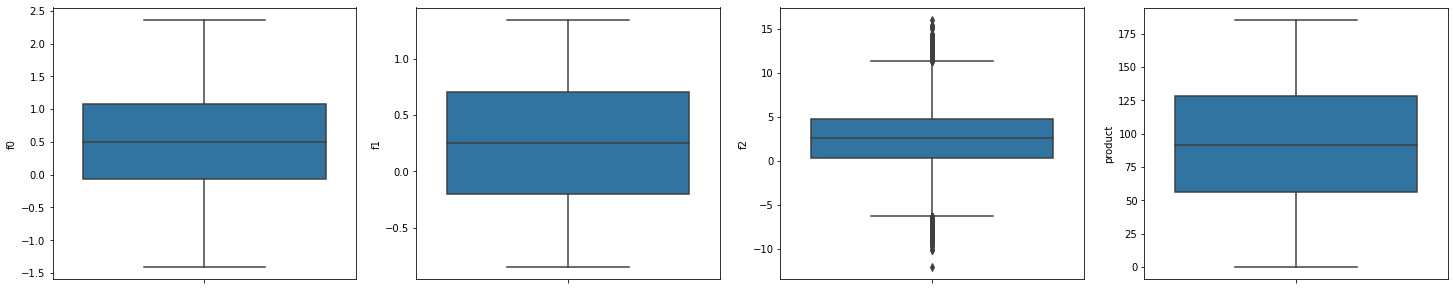

Второй регион


,f0,f1,f2,product
count,99996.000000,99996.000000,99996.000000,99996.000000
mean,1.141209,-4.796608,2.494501,68.823916
std,8.965815,5.119906,1.703579,45.944663
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011475,57.085625
75%,8.620964,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


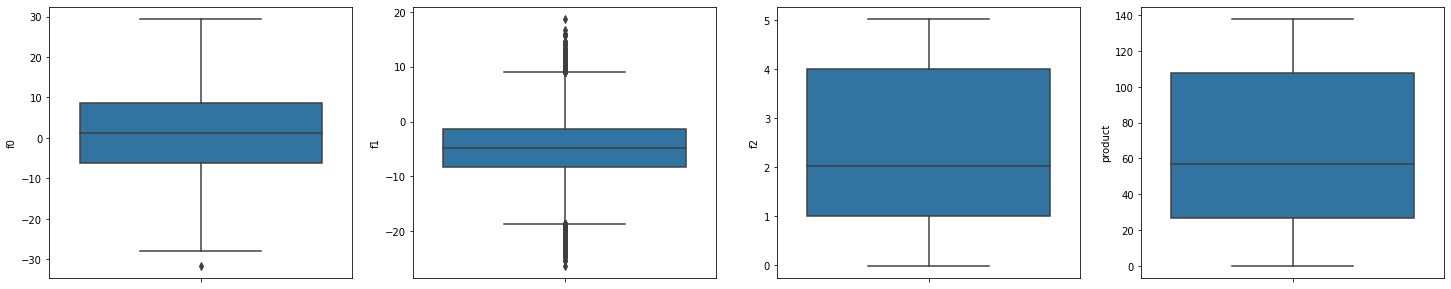

Третий регион


,f0,f1,f2,product
count,99996.000000,99996.000000,99996.000000,99996.000000
mean,0.002002,-0.002159,2.495084,94.998342
std,1.732052,1.730397,3.473482,44.749573
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162328,-1.174841,0.130269,59.450028
50%,0.009424,-0.009661,2.484236,94.925026
75%,1.158477,1.163523,4.858720,130.586815
max,7.238262,7.844801,16.739402,190.029838


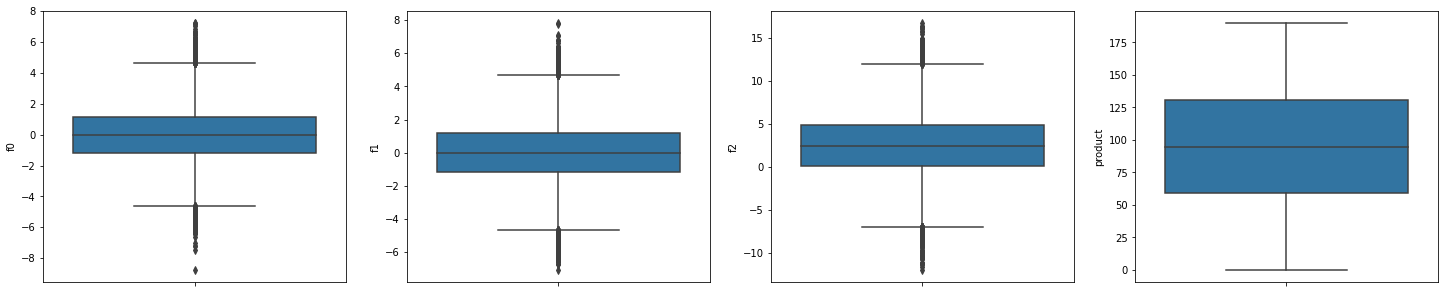

In [7]:
for data, region in zip(data_list, region_list):
    
    print(region)
    display (data.describe(include='all'))
    fig, axes = plt.subplots(1, 4,  figsize=(25,5))
    sns.boxplot(data=data, y ='f0',ax=axes[0])
    sns.boxplot(data=data, y ='f1',ax=axes[1])
    sns.boxplot(data=data, y ='f2',ax=axes[2])
    sns.boxplot(data=data, y ='product',ax=axes[3])
    plt.show()
    

####  В некоторых столбцах  датафреймов есть выбросы. Эти данные  необходимо удалить.

Количество удаленных строк:  506
Количество удаленных строк:  637
Количество удаленных строк:  1996
Первый регион


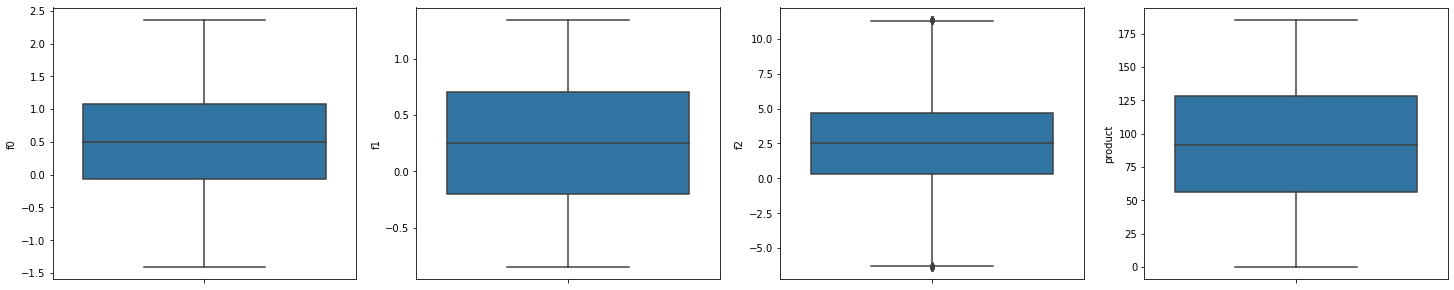

Второй регион


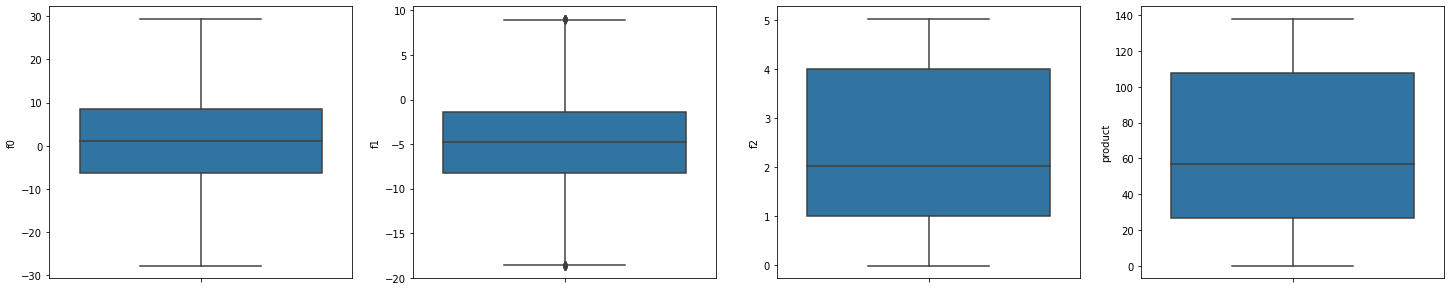

Третий регион


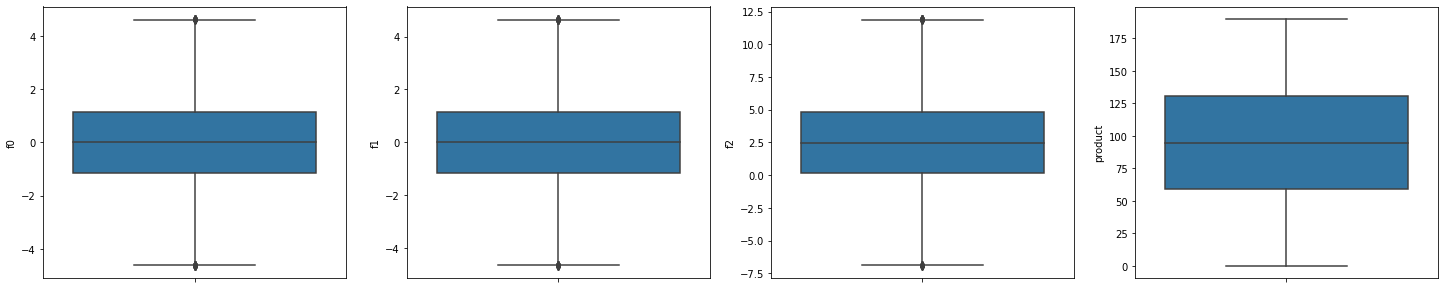

In [8]:
# считаем выбросами значения > Q3 + 1,5*IQR или Q1 – 1,5*IQR
# наишем  функцию  обнаруживающую и удаляющие выбросы из датафрейма
def remove_ouliers(df):
        df1 = df.copy()
        del_index = []       
        for col in df.columns:
            q1 = df[col].quantile(0.25)
            q3 = df[col].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 -(1.5 * iqr) 
            upper_bound = q3 +(1.5 * iqr)
            for index, value in zip(df[col].index, df[col]):
                if value < lower_bound or value > upper_bound:            
                    if index not in del_index:
                        del_index.append(index) 
       
                
        print('Количество удаленных строк: ', len(del_index))
        df1.drop(del_index, axis = 0, inplace = True)
        return(df1)
# Применим  функцию к датафреймам 
df_0_clean = remove_ouliers(df_0)
df_1_clean = remove_ouliers(df_1)
df_2_clean = remove_ouliers(df_2)

data_list_clean =[df_0_clean, df_1_clean, df_2_clean]
# выполним проверку
for data, region in zip(data_list_clean, region_list):
    print(region)
    fig, axes = plt.subplots(1, 4,  figsize=(25,5))
    sns.boxplot(data=data, y ='f0',ax=axes[0])
    sns.boxplot(data=data, y ='f1',ax=axes[1])
    sns.boxplot(data=data, y ='f2',ax=axes[2])
    sns.boxplot(data=data, y ='product',ax=axes[3])
    plt.show()

#### Проверим корреляцию между признаками для каждого датафрейма. 

In [9]:
for data, region in zip(data_list_clean, region_list):
    print(region)
    display(data.corr())

Первый регион


,f0,f1,f2,product
f0,1.000000,-0.440710,-0.003399,0.143558
f1,-0.440710,1.000000,0.001139,-0.192743
f2,-0.003399,0.001139,1.000000,0.480125
product,0.143558,-0.192743,0.480125,1.000000


Второй регион


,f0,f1,f2,product
f0,1.000000,0.178928,-0.001671,-0.030390
f1,0.178928,1.000000,-0.002765,-0.010185
f2,-0.001671,-0.002765,1.000000,0.999397
product,-0.030390,-0.010185,0.999397,1.000000


Третий регион


,f0,f1,f2,product
f0,1.000000,0.000606,0.000457,-0.002947
f1,0.000606,1.000000,0.000728,-0.000961
f2,0.000457,0.000728,1.000000,0.441187
product,-0.002947,-0.000961,0.441187,1.000000


####  Для третьего региона корреляция между признаками f0, f1 и f2 отсутсвует. Для второго региона наблюдается  очень слабая  положительная корреляция  между признакасм f0 и f1, коэффициент корреляции равен 0,18. Для первого региона наблюдается слабая отрицательная корреляция между  f0  и  f1,  коэффициент корреляции равен -0,44.  Коэффициенты корреляции малы и  корреляции между признаками f0, f1 и f2 мы не будем принимать в расчет.  Заметим, что для второго реоиона  наблюдается сильная положительная корреляция между  признаком f2  и целевой переменной product, коэффициент корреляции равен 1, отмечается высокая степень связи между переменными.

### Изучили и подготовили данные для дальнейших исследований
*  Пропуски и дубликаты в данных отсутсвуют. 
*  Типы столбцов, названия столбцов - корректны.
*  Удален столбец "id" не несущиЙ  ценности для дальнейшего  исследования. 
*  Удалены выбросы в данных, потери в данных составили менее 2%. 
*  Изучена корреляция между признаками. Корреляции между признаками f0, f1 и f2 мы не будем принимать в расчет.

## Обучение и проверка модели

####  Проведем разделение данных  на обучающую и валидационную выборки для каждого региона в соотношении 75/25.

In [10]:
def split_data(df, target):
        features = df.drop(target, axis=1) 
        target = df[target]
        features_train, features_valid, target_train, target_valid = train_test_split(features, target,
                                                                            test_size=0.25, random_state=12345)
        return features_train, features_valid, target_train, target_valid
    
features_train_0, features_valid_0, target_train_0, target_valid_0 = split_data(df_0_clean , 'product')
features_train_1, features_valid_1, target_train_1, target_valid_1 = split_data(df_1_clean , 'product')
features_train_2, features_valid_2, target_train_2, target_valid_2 = split_data(df_2_clean , 'product')

print(features_train_0.shape, features_valid_0.shape, target_train_0.shape, target_valid_0.shape)
print(features_train_1.shape, features_valid_1.shape, target_train_1.shape, target_valid_1.shape)
print(features_train_2.shape, features_valid_2.shape, target_train_2.shape, target_valid_2.shape)


(74613, 3) (24871, 3) (74613,) (24871,)
(74519, 3) (24840, 3) (74519,) (24840,)
(73500, 3) (24500, 3) (73500,) (24500,)


####  Мы планируем использовать для обучения модели метод линейной регресии.   Метод линейной регрессии  не требует масштабирования признаков, поэтому масштабирование признаков мы производить не будем.

#### Обучим  модель  методом линейной регресии на обучающей выборке. Сделаем предсказания на валидационной выборке. Посчитаем средний объем запасов в скважине и RMSE модели. Для каждого региона создадим новый датафрейм содержащий  значения реальной добычи и предсказанных значений.

In [11]:
def model_calculate (features_train, features_valid, target_train, target_valid):
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    predictions_mean = predictions.mean()
    rmse = mean_squared_error(target_valid, predictions) ** 0.5
    data = {'real_product' : target_valid,
            'predicted_product' : predictions}
    df = pd.DataFrame(data)
    df.reset_index(drop=True, inplace=True)
    return df, predictions_mean, rmse

df_0, predictions_mean_0, rmse_0 = model_calculate (features_train_0, features_valid_0, target_train_0, target_valid_0)
df_1, predictions_mean_1, rmse_1 = model_calculate (features_train_1, features_valid_1, target_train_1, target_valid_1)
df_2, predictions_mean_2, rmse_2 = model_calculate (features_train_2, features_valid_2, target_train_2, target_valid_2)

print(df_0.head())
print(df_1.head())
print(df_2.head())

   real_product  predicted_product
0    145.394715          91.482070
1     91.092807         104.962312
2     19.882164          61.012668
3    132.684080          90.976450
4     96.000233         124.541000
   real_product  predicted_product
0     53.906522          52.875698
1     30.132364          29.678760
2    137.945408         137.712802
3     80.859783          80.186640
4    110.992147         110.567415
   real_product  predicted_product
0     66.042218          98.874316
1    131.964461         129.013976
2      5.848186          63.876508
3     62.546089          96.280096
4     46.289429          61.685399


In [12]:
table = pd.DataFrame({'Параметр':['Средний предсказанный запас сырья', 'RMSE модели'],
                      'Первый регион':[predictions_mean_0, rmse_0],
                      'Второй регион ':[predictions_mean_1, rmse_1],
                      'Третий регилн':[predictions_mean_2, rmse_2]})
display(table)


,Параметр,Первый регион,Второй регион,Третий регилн
0,Средний предсказанный запас сырья,92.490393,68.829535,94.541696
1,RMSE модели,37.828145,0.890832,40.434291


### Для второго региона средний предсказанный запас сырья в скважине 68,8 тыс. баррелей значительно меньше других регионов (92,5 тыс. баррелей  и 94,5  тыс. баррелей для первого и третьего регинов соответсвенно) , однако  RMSE модели второго региона имеет самое низкое значение 0,89  в отличие от других регионов, где RMSE составляет 38- 40.

## Подготовка к расчёту прибыли

#### Расчитаем объем добычи продукта для безубыточной разработки региона. И найдем среднее количество продукта в месторождениях необходимое для этого.

In [13]:
budget_per_region = 10000000 # бюджет на разработку в регионе, тыс.руб
wells_total = 500 # 500 точек при исследовании
wells_selected = 200 # 200 лучших для разработки скважин
product_income = 450 # доход с каждой единицы продукта (1 тыс. баррелей), тыс. руб.
damage_threshold = 0.025 # порог убытков
non_damage_per_region = (budget_per_region/product_income)  # объем добычи   в регионе для безубыточной разработки
non_damage_well = non_damage_per_region/wells_selected # объем добычи скважины для безубыточной разработки
print("Объем добычи для безубыточной разработки региона, тыс. баррелей", round(non_damage_per_region,2))
print("Объем добычи для безубыточной разработки скважины, тыс. баррелей", round(non_damage_well,2))

Объем добычи для безубыточной разработки региона, тыс. баррелей 22222.22
Объем добычи для безубыточной разработки скважины, тыс. баррелей 111.11


#### Напишем функцию для расчета прибыли:

In [14]:
def revenue(true_target, pred_target, count):
    pred_target_sorted = pred_target.sort_values(ascending=False)
    selected = true_target[pred_target_sorted.index][:count]
    return product_income * selected.sum() - budget_per_region


<div class="alert alert-block alert-success">
<b>Успех:</b> Ф-ция для подсчета прибыли определена верно
</div>


### Минимальное количество баррелей нефти для безубыточной разработки составило  111.11 тыс баррелей. Это больше средних предсказанных запасов продукта в каждом регионе (92.5 тыс. баррелей в первом регионе; 68.8 тыс. баррелей во втором регионе и 94.5 тыс. баррелей в в третьем регионе ). Но в регионах есть как хорошие, так и плохие скважины, и нам нужно выбрать 200 скважин, приносящих наибольшую прибыль.

<div class="alert alert-block alert-success">
<b>Успех:</b> Значение для безубыточной разработки посчитано верно, с выводом согласен  
</div>


## Расчёт прибыли и рисков 

#### Применим технику Bootstrap с 1000 выборок, чтобы найти  среднюю прибыль, 95%-й доверительный интервал и риск убытков для каждого региона.

In [15]:
# cгенерируем 1000 выборок по 500 случайных скважин в каждой
# найдем предсказания модели, соответствующие этим скважинам
# посчитаем суммарную прибыль с 200 лучших скважин
state = np.random.RandomState(12345)
def bootstrap (target, probs):
    
    values = []
    count = 0  # убыточные скважины
    for i in range(1000):
        target_subsample = target.sample(500, replace=True, random_state=state)
        probs_subsample = probs[target_subsample.index] 
        profit = revenue(target_subsample, probs_subsample, 200)
        if profit< 0:  #  убытки
            count += 1  
        values.append(profit)
    
    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    medium = values.mean()
    risk = count / 1000
    return medium, lower, upper, risk

<div class="alert alert-block alert-success">
<b>Успех:</b> С бутстрапом тоже все в порядке, метрики считаются верным образом!  
</div>

In [16]:

medium_0, lower_0, upper_0, risk_0 = bootstrap(df_0['real_product'], df_0['predicted_product'])
medium_1, lower_1, upper_1, risk_1 = bootstrap(df_1['real_product'],df_1['predicted_product'])
medium_2, lower_2, upper_2, risk_2 = bootstrap(df_2['real_product'], df_2['predicted_product'])

In [17]:
table_final = pd.DataFrame({'Параметр':['Средняя прибыль, тыс.руб.', 'Начало доверительного интервала',
                                        'Конец доверительного интервала', 'Риск убытков'],
                            'Первый регион':[medium_0, lower_0, upper_0, risk_0],
                            'Второй регион':[medium_1, lower_1, upper_1, risk_1],
                            'Третий регион':[medium_2, lower_2, upper_2, risk_2]})

display(table_final)

,Параметр,Первый регион,Второй регион,Третий регион
0,"Средняя прибыль, тыс.руб.",382521.378132,512038.452985,339845.949187
1,Начало доверительного интервала,-129462.771589,87444.540553,-206970.354384
2,Конец доверительного интервала,890340.081364,932953.307486,873527.368339
3,Риск убытков,0.080000,0.010000,0.105000


### Наиболее выгодным  для разработки является  второй регион, имеющий наибольшую среднюю прибыль 512 мил. рублей.  С вероятностью 95% прибыль  второго региона окажется в промежутке от 87,4 до 932,9 млн руб.  В этом регионе самые маленькие риски убытков - 1%.  В первом и третьем регионах приьбыль меньше (382,5 мил. рублей, 339,8 мил. рублей)  и риски убытков выше (8% и 10,5% соответсвенно)